## План работы

[1. Подготовка данных](#1.)<br>
    [1.1. Откроем файлы и изучим их](#1.1.)<br>
    [1.2. Проведем предобработку данных](#1.2.)<br>
    [1.3. Проверим расчет эффективности обогащения](#1.3.)<br>
    [1.4. Проанализируем признаки, недоступные в тестовой выборке](#1.4.)<br>
    
[2. Исследовательский анализ данных](#2.)<br>
    [2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#2.1.)<br>
    [2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках](#2.2.)<br>
    [2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах](#2.3.)<br>
    
[3. Построение и обучение модели](#3.)<br>
    [3.1. Напишем функцию для вычисления итоговой sMAPE](#3.1.)<br>
    [3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке](#3.2.)<br>

# 1. Подготовка данных <a id = "1."> </a>

## 1.1. Откроем файлы и изучим их <a id = "1.1."> </a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statistics
import math
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore') 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
%matplotlib inline

gold_recovery_train = pd.read_csv('E:\Документы прочие\IT\Яндекс практикум\Project\Сборный проект 2 Обогощение золотосодержащей руды\gold_recovery_train.csv')
gold_recovery_test = pd.read_csv('E:\Документы прочие\IT\Яндекс практикум\Project\Сборный проект 2 Обогощение золотосодержащей руды\gold_recovery_test.csv')
gold_recovery_full = pd.read_csv('E:\Документы прочие\IT\Яндекс практикум\Project\Сборный проект 2 Обогощение золотосодержащей руды\gold_recovery_full.csv')

def data_info(data):
    '''
    Функция принимает в качестве аргумента датасет.
    Функция выводит информацию о датасете и первые 10 строк датасета, а также количество дубликатов.
    '''
    data.info()
    display(data.head(10))
    print('Количество дубликатов в данных:', data.duplicated().sum())

def nulls(data, col):
    '''
    Функция принимает в качестве аргумента датасет и название колонки.
    Функция выводит информацию о доле пропусков в выбранном столбце датасета.
    '''
    return data[col].isnull().sum()/data[col].count().sum()

def whiskers(data):
    '''
    Функция принимает в качестве аргумента колонку датасета.
    Функция выводит информацию о нижней и верхней границе усов.
    '''
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3-Q1
    low_whisker = Q1 - 1.5*IQR
    high_whisker = Q1 + 1.5*IQR
    return low_whisker, high_whisker

Для анализа мы будем использовать датасеты: gold_recovery_train, gold_recovery_test, gold_recovery_full. Они содержат данные с параметрами добычи и очистки.
1. gold_recovery_train — обучающая выборка;
2. gold_recovery_test — тестовая выборка;
3. gold_recovery_full — исходные данные.

In [2]:
data_info(gold_recovery_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          16860 non-null  int64  
 1   date                                                16860 non-null  object 
 2   final.output.concentrate_ag                         16788 non-null  float64
 3   final.output.concentrate_pb                         16788 non-null  float64
 4   final.output.concentrate_sol                        16490 non-null  float64
 5   final.output.concentrate_au                         16789 non-null  float64
 6   final.output.recovery                               15339 non-null  float64
 7   final.output.tail_ag                                16794 non-null  float64
 8   final.output.tail_pb                                16677 non-null  float64


,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.0026

Количество дубликатов в данных: 0


Датасет gold_recovery_train размером в 16860 строк содержит 87 колонок и содержит данные 2-х типов: float64, object. В датасете отсутствуют дубликаты. Названия колонок приведены к нижнему регистру. Данные содержат пропуски.

In [3]:
data_info(gold_recovery_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Unnamed: 0                                  5856 non-null   int64  
 1   date                                        5856 non-null   object 
 2   primary_cleaner.input.sulfate               5554 non-null   float64
 3   primary_cleaner.input.depressant            5572 non-null   float64
 4   primary_cleaner.input.feed_size             5856 non-null   float64
 5   primary_cleaner.input.xanthate              5690 non-null   float64
 6   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 10  primary_clea

,Unnamed: 0,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,

Количество дубликатов в данных: 0


Датасет gold_recovery_test размером в 5856 строк содержит 53 колонки и содержит данные 2-х типов: float64, object. В датасете отсутствуют дубликаты. Названия колонок приведены к нижнему регистру. Данные содержат пропуски.

In [4]:
data_info(gold_recovery_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          22716 non-null  int64  
 1   date                                                22716 non-null  object 
 2   final.output.concentrate_ag                         22627 non-null  float64
 3   final.output.concentrate_pb                         22629 non-null  float64
 4   final.output.concentrate_sol                        22331 non-null  float64
 5   final.output.concentrate_au                         22630 non-null  float64
 6   final.output.recovery                               20753 non-null  float64
 7   final.output.tail_ag                                22633 non-null  float64
 8   final.output.tail_pb                                22516 non-null  float64


,Unnamed: 0,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.0026

Количество дубликатов в данных: 0


Датасет gold_recovery_full размером в 22716 строк содержит 87 колонок и содержит данные 2-х типов: float64, object. В датасете отсутствуют дубликаты. Названия колонок приведены к нижнему регистру. Данные содержат пропуски.

### Описание данных в датасетах:

#### Технологический процесс
1. Rougher feed — исходное сырье
2. Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate **— ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
3. Rougher process (англ. «грубый процесс») — флотация
4. Rougher tails — отвальные хвосты
5. Float banks — флотационная установка
6. Cleaner process — очистка
7. Rougher Au — черновой концентрат золота
8. Final Au — финальный концентрат золота

#### Параметры этапов
1. air amount — объём воздуха
2. fluid levels — уровень жидкости
3. feed size — размер гранул сырья
4. feed rate — скорость подачи

### Наименование признаков:

#### Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]<br/>

#### Возможные значения для блока [этап]:
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

#### Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

Согласно условиям задачи необходимо предсказать 2 признака, соответственно они и будут являться для нас целевыми:
#### Целевые признаки:
1.	rougher.output.recovery - эффективность обогащения чернового концентрата;
2.	final.output.recovery - эффективность обогащения финального концентрата .

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей выборке. Также в тестовом наборе нет целевых признаков.

### Вывод

Была изучена общая информация о полученных данных. Данные представляют собой 3 выборки: обучающую, тестовую и исходные данные. Они не содержат дубликатов, но содержат пропуски. Пропуски данных могут быть вызваны как ошибкой данных, так и тем, что данные показатели во времени не были измерены. В тестовой выборке отсутствуют некоторые колонки в связи с тем, что некоторые параметры недоступны из-за того, что расчитываются позже, и также отсутствуют целевые признаки.

## 1.2. Проведем предобработку данных  <a id = "1.2."> </a>

Проведем предобработку данных. Для дальнейшего тестирования необходимо подтянуть по колонке с датой целевые признаки в тестовую выборку. Они будут необходимы для оценки результатов обученных моделей.

In [5]:
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['date', 'final.output.recovery', 'rougher.output.recovery']], 
                                              how = 'left', on='date')

Нам известно, что обучающая и полная выборки содержат пропуски в столбцах с целевыми признаками. Удалим из данных объекты, содержащие пропуски в колонках с целевыми признаками, так как они и есть цель нашего предсказания. Заполнив пропуски в целевых признаках мы можем в дальнейшем исказить качество обученной модели.

In [6]:
gold_recovery_train = (gold_recovery_train.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'])
                                                .reset_index(drop=True))
gold_recovery_test = (gold_recovery_test.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'])
                                                .reset_index(drop=True))
gold_recovery_full = (gold_recovery_full.dropna(subset = ['final.output.recovery', 'rougher.output.recovery'])
                                                .reset_index(drop=True))

Нам известно, что выборки также содержат пропуски и в колонках содержащих признаки. Так как данные индексируются датой и временем полученной информации и соседние по времени параметры часто схожи, то мы можем заполнить пропуски в этих колонках соседними значениями.

In [7]:
# преобразуем колонку date в формат DateTime
gold_recovery_train['date'] = pd.to_datetime(gold_recovery_train['date'], format = '%Y-%m-%d %H:%M:%S')
gold_recovery_test['date'] = pd.to_datetime(gold_recovery_test['date'], format = '%Y-%m-%d %H:%M:%S')
gold_recovery_full['date'] = pd.to_datetime(gold_recovery_full['date'], format = '%Y-%m-%d %H:%M:%S')

# отсортируем от самой ранней до самой поздней даты
gold_recovery_train = gold_recovery_train.sort_values(by=['date'])
gold_recovery_test = gold_recovery_test.sort_values(by=['date'])
gold_recovery_full = gold_recovery_full.sort_values(by=['date'])

Заполним пропуски признаками ближайших объектов.

In [8]:
gold_recovery_train = gold_recovery_train.ffill()
gold_recovery_test = gold_recovery_test.ffill()
gold_recovery_full = gold_recovery_full.ffill()

### Вывод

Данные были очищенны от объектов с пропусками в целевых признаках, а остальные признаки заполнены ближайшими значениями. В тестовую выборку были подтянуты целевые признаки из полной выборки.

## 1.3. Проверим расчет эффективности обогащения <a id = "1.3."> </a>

Вычислим эффективность на обучающей выборке для признака rougher.output.recovery (эффективность обогащения чернового концентрата). 

Формула расчета эффективности:

$Recovery=C*(F-T) / F*(C-T)*100$

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [9]:
C = gold_recovery_train['rougher.output.concentrate_au']
F = gold_recovery_train['rougher.input.feed_au']                           
T = gold_recovery_train['rougher.output.tail_au']

# вычислим эффективность по формуле и заполним значения в таблице
gold_recovery_train['rougher.output.recovery.check'] = ((C*(F-T)
                                                        /(F*(C-T)))*100)
# очистим целевой признак и предсказания от пропусков
gold_recovery_train = gold_recovery_train.dropna(subset = ['rougher.output.recovery.check', 'rougher.output.recovery'])

Найдем MAE между нашими расчётами и значением признака.

In [10]:
mae = mean_absolute_error(gold_recovery_train['rougher.output.recovery'], gold_recovery_train['rougher.output.recovery.check'])
print('Среднее абсолютное отклонение:', mae)

Среднее абсолютное отклонение: 9.682896147825551e-15


Формула расчёта эффективности c высокой точностью вычисляет значение показателя. 

In [11]:
# очистим из датасета признаки, добавленные для расчета.
gold_recovery_train = gold_recovery_train.drop(columns = ['rougher.output.recovery.check'])

### Вывод

Мы проверили расчет эффективности обогащения и пришли к выводу, что данный расчет является очень точным. Расхождения близки к 0.

## 1.4. Проанализируем признаки, недоступные в тестовой выборке <a id = "1.4."> </a>

Для того, чтобы проанализировать признаки, недоступные в тестовой выборке определим весь перечень доступных признаков.

In [12]:
# перечень доступных признаков
train_columns = gold_recovery_train.columns
# признаки в тестовой выборке
test_columns = gold_recovery_test.columns

Отфильтруем те признаки, которых нет в тестовой выборке.

In [13]:
# признаки, которых нет в тестовой выборке
exept_columns = train_columns.difference(test_columns)
print(pd.Series(exept_columns.values))

0                           final.output.concentrate_ag
1                           final.output.concentrate_au
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                                  final.output.tail_ag
5                                  final.output.tail_au
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                 primary_cleaner.output.concentrate_ag
9                 primary_cleaner.output.concentrate_au
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                       primary_cleaner.output.tail_ag
13                       primary_cleaner.output.tail_au
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                      rougher.calculation.au_pb_ratio
17    rougher.calculation.floatbank10_sulfate_to

В тестовой выборке отсутствуют параметры продукта для всех этапов восстановления: флотации, первичной и вторичной очистки и финала. Также отсутствуют расчетные характеристики. Целевые признаки rougher.output.recovery и final.output.recovery были добавлены на этапе предобработки данных.

### Вывод

Нами были проанализированы признаки, недоступные в тестовой выборке. Это выходные (output) и некоторые расчетные (calculation) характеристики процесса. Эти признаки недоступны в тестовой выборке, так как их невозможно получить/измерить во время выполнения технологического процесса.

## Вывод

Были проанализированы данные, заполнены пропуски признаков в объектах и удалены объекты с пропусками в целевых признаках. Колонки были приведены к их соответствующим типам данных, а также была проведена проверка на наличие дубликатов. Таже был проверен на корректность расчет эффективности обогащения и проанализированы признаки, недоступные в тестовой выборке.

# 2. Анализ данных <a id = "2."> </a>

## 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки <a id = "2.1."> </a>

Для анализа будем использовать полную выборку. Определим колонки, показывающие концентрацию определенного металла на разных этапах очистки.

In [14]:
# концентрация Au
au = ['rougher.input.feed_au'] + gold_recovery_full.columns[gold_recovery_full.columns.str.contains('concentrate_au')][::-1].to_list()
# концентрация Ag
ag = ['rougher.input.feed_ag'] + gold_recovery_full.columns[gold_recovery_full.columns.str.contains('concentrate_ag')][::-1].to_list()
# концентрация Pb
pb = ['rougher.input.feed_pb'] + gold_recovery_full.columns[gold_recovery_full.columns.str.contains('concentrate_pb')][::-1].to_list()

### Au (золото)

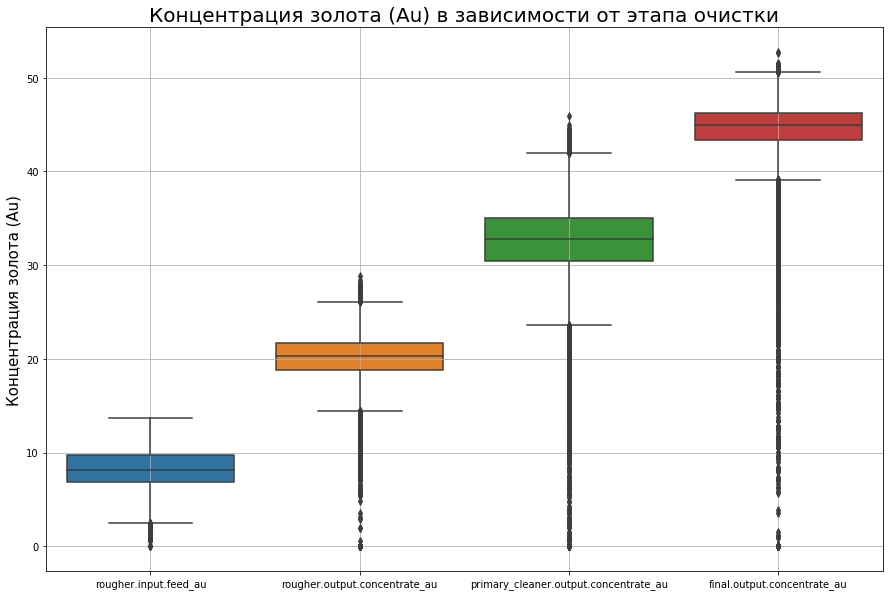

In [15]:
plt.figure(figsize=(15,10))
sns.boxplot(data = gold_recovery_full[au])
plt.title('Концентрация золота (Au) в зависимости от этапа очистки',fontsize=20)
plt.ylabel('Концентрация золота (Au)', fontsize=15)
plt.grid(True)
plt.show()

Мы видим, что концентрация золота на этапе смеси золотоносной руды наименьшая. После прохождения этапа флотации и превращения в черновой концентрат концентрация золота значительно вырастает. Далее после этапа первичной очистки концентрация золота также увеличивается и на финальном этапе (после вторичной очистки) концентрат достигает максимального значения. Данное увеличение концентрации соответствует логике процесса обогощения золотоносной руды. Из графика мы видим, что в данных присутствуют выбросы на всех этапах очистки.

### Ag (серебро)

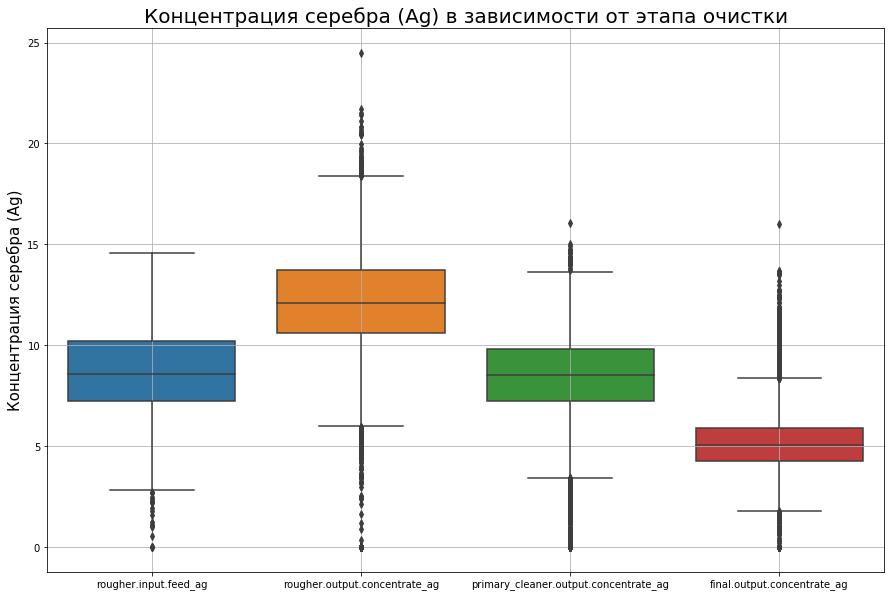

In [16]:
plt.figure(figsize=(15,10))
sns.boxplot(data = gold_recovery_full[ag])
plt.title('Концентрация серебра (Ag) в зависимости от этапа очистки',fontsize=20)
plt.ylabel('Концентрация серебра (Ag)', fontsize=15)
plt.grid(True)
plt.show()

На этапе смеси золотосодержащей руды концентрация серебра показывает среднее значение, так как помимо серебра в состав входит множество других веществ. Далее концентрация серебра показывает картину противоположную золоту. После этапа флотации ее концентрация уменьшается. Свою максимальную концентрацию серебро имеет после флотации, когда оно входит в состав чернового концентрата. Наименьшую концентрацию серебро имеет уже после прохождения процессов очистки. Данное уменьшение концентрации также соответствует логике процесса обогощения золотоносной руды. Из графика мы видим, что в данных присутствуют выбросы на всех этапах очистки.

### Pb (свинец)

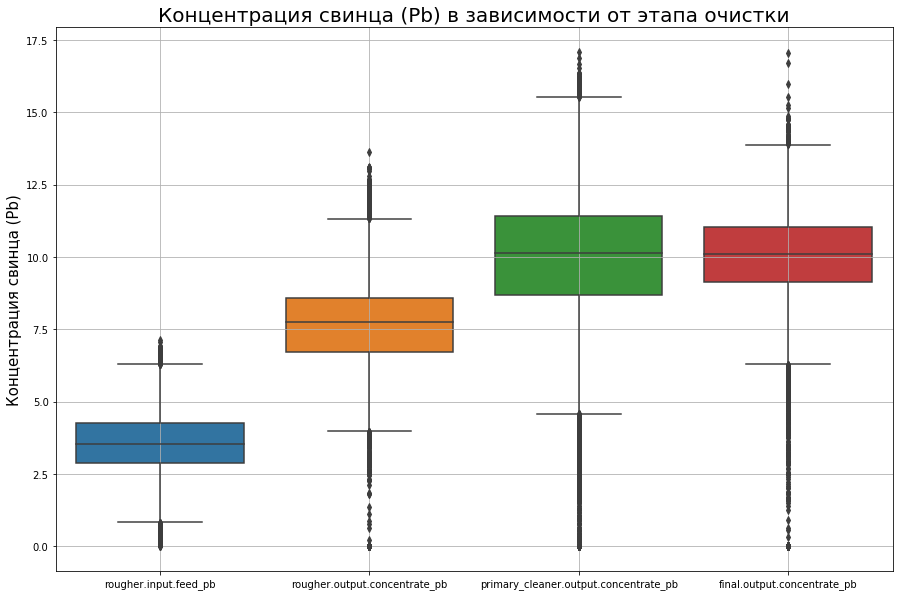

In [17]:
plt.figure(figsize=(15,10))
sns.boxplot(data = gold_recovery_full[pb])
plt.title('Концентрация свинца (Pb) в зависимости от этапа очистки',fontsize=20)
plt.ylabel('Концентрация свинца (Pb)', fontsize=15)
plt.grid(True)
plt.show()

Концентрация имеет наименьшие значения, когда свинец входит в состав смеси золотоносной руды. Затем после флотации концентрация увеличивается. Наибольшие значения концентрации свинец имеет после этапов первичной и вторичной очистки. При этом концентрация на этапе первичной очистки имеет большой разброс. Предположительно варирование концентрации свинца в руде связано с непостоянством состава неочищенной руды и различной концентрацией  в составе отстрельных хвостов.

### Вывод

Мы провели анализ и посмотрели, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Концентрация этих металлов соответствует технологическим процессам обогощения руды. Однако мы видим, что все показатели на всех этапах содержат выбросы данных. Причем данные содержат и нулевые значения и значения близкие к нулю. Вероятно это связано с особенностями технологического процесса или несовершенством методов замера состава.

## 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках <a id = "2.2."> </a>

Обучающая и тестовая выборка содержат данные о размерах гранул сырья на этапе флотации и первичной очистки. Проанализируем и сравним распределения этих данных.

### Флотация

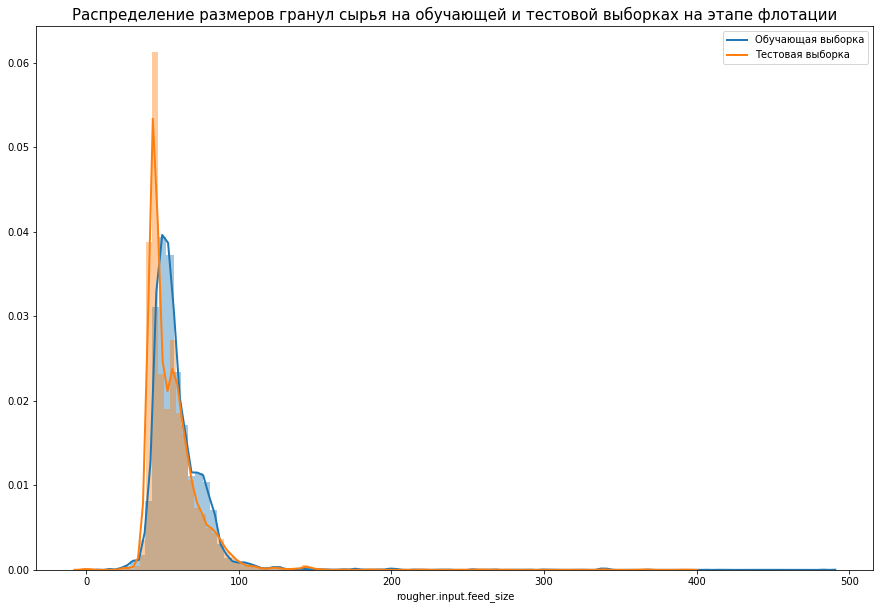

In [18]:
plt.figure(figsize=(15, 10))
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках на этапе флотации',fontsize=15)
sns.distplot(gold_recovery_train['rougher.input.feed_size'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Обучающая выборка"})
sns.distplot(gold_recovery_test['rougher.input.feed_size'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Тестовая выборка"})

Мы наблюдаем небольшое смещение графика и гистограммы плотности у тестовой выборки относительно обучающей. Можно судить о слабом негативного влияния на оценку модели в дальнейшем.

### Первичная очистка

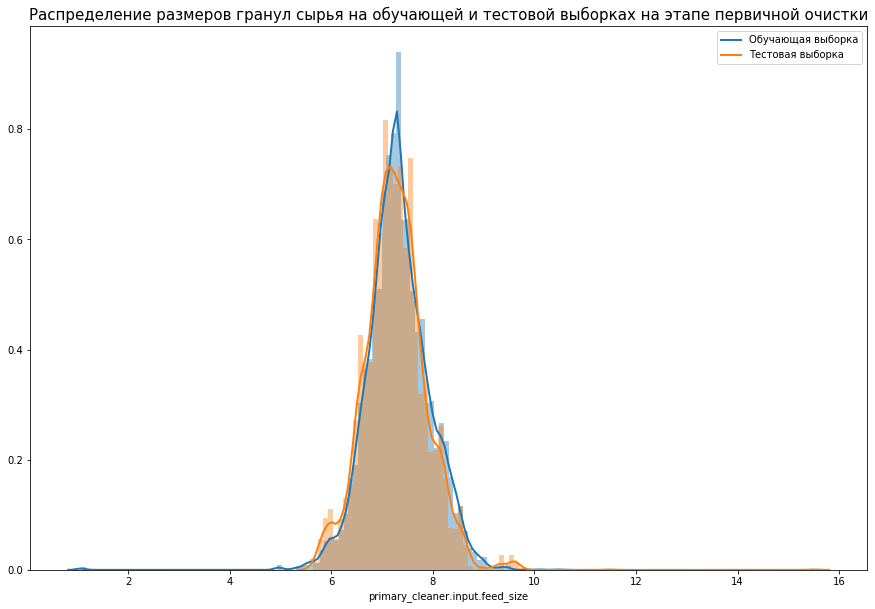

In [19]:
plt.figure(figsize=(15, 10))
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках на этапе первичной очистки',fontsize=15)
sns.distplot(gold_recovery_train['primary_cleaner.input.feed_size'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Обучающая выборка"})
sns.distplot(gold_recovery_test['primary_cleaner.input.feed_size'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Тестовая выборка"})

Гистограммы и графики плотности распределения у обучающей и тестовой выборки различаются не существенно. Они имеют вид нормального распределения. Можно судить об осутствии негативного влияния на оценку модели в дальнейшем.

### Вывод

Мы провели сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Можно сделать вывод о том, что распределения отличаются не существенно, что слабо повлияет на оценку модели в дальнейшем.

## 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах <a id = "2.3."> </a>

Для исследования суммарной концентрации всех веществ на разных стадиях произведем расчет.

In [20]:
# посчитаем суммарную концентрацию всех веществ в смеси золотоносной руды
gold_recovery_full['rougher_input_feed'] = (gold_recovery_full['rougher.input.feed_ag'] + 
                                 gold_recovery_full['rougher.input.feed_pb']+
                                 gold_recovery_full['rougher.input.feed_sol']+
                                 gold_recovery_full['rougher.input.feed_au'])


# посчитаем суммарную концентрацию всех веществ в черновом концентрате
gold_recovery_full['rougher_output_concentrate'] = (gold_recovery_full['rougher.output.concentrate_ag'] + 
                                 gold_recovery_full['rougher.output.concentrate_pb']+
                                 gold_recovery_full['rougher.output.concentrate_sol']+
                                 gold_recovery_full['rougher.output.concentrate_au'])

# посчитаем суммарную концентрацию всех веществ после первичной очистки
gold_recovery_full['primary_cleaner_output_concentrate'] = (gold_recovery_full['primary_cleaner.output.concentrate_ag'] + 
                                         gold_recovery_full['primary_cleaner.output.concentrate_pb']+
                                         gold_recovery_full['primary_cleaner.output.concentrate_sol']+
                                         gold_recovery_full['primary_cleaner.output.concentrate_au'])

# посчитаем суммарную концентрацию всех веществ в финальном концентрате
gold_recovery_full['final_output_concentrate'] = (gold_recovery_full['final.output.concentrate_ag']+
                               gold_recovery_full['final.output.concentrate_pb']+
                               gold_recovery_full['final.output.concentrate_sol']+
                               gold_recovery_full['final.output.concentrate_au'])

Построим гистрограммы плотности распределения концентрации всех веществ на разных стадиях.

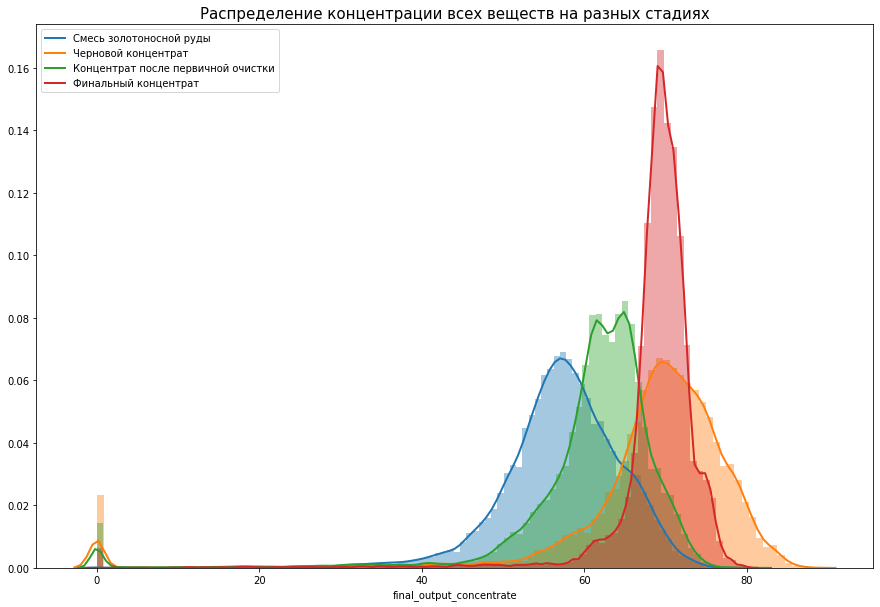

In [21]:
plt.figure(figsize=(15, 10))
plt.title('Распределение концентрации всех веществ на разных стадиях',fontsize=15)
sns.distplot(gold_recovery_full['rougher_input_feed'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Смесь золотоносной руды"})
sns.distplot(gold_recovery_full['rougher_output_concentrate'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Черновой концентрат"})
sns.distplot(gold_recovery_full['primary_cleaner_output_concentrate'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Концентрат после первичной очистки"})
sns.distplot(gold_recovery_full['final_output_concentrate'], 
             bins=100, kde=True, kde_kws={"lw": 2, "label": "Финальный концентрат"})

Построим ящики с усами для распределения концентрации всех веществ на разных стадиях.

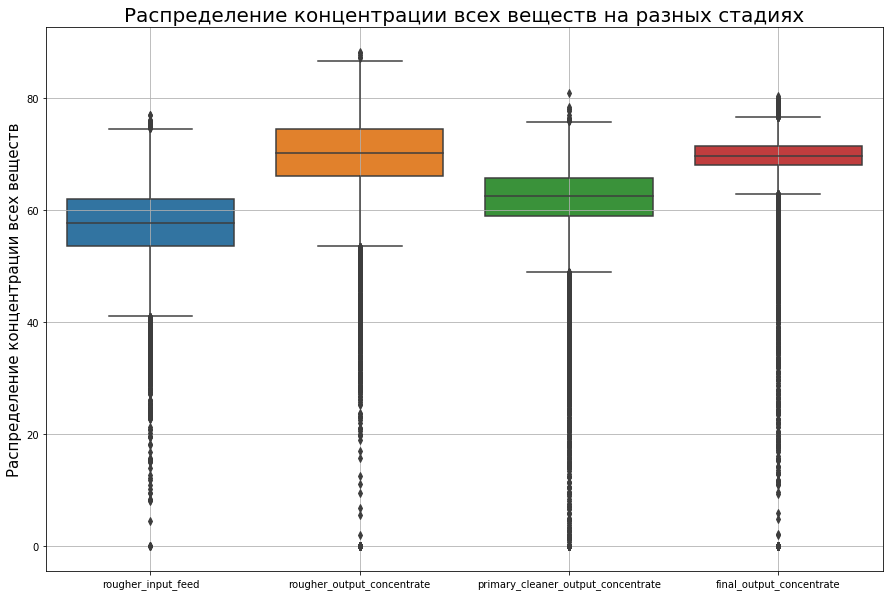

In [22]:
plt.figure(figsize=(15,10))
sns.boxplot(data = gold_recovery_full[['rougher_input_feed','rougher_output_concentrate','primary_cleaner_output_concentrate','final_output_concentrate']])
plt.title('Распределение концентрации всех веществ на разных стадиях', fontsize=20)
plt.ylabel('Распределение концентрации всех веществ', fontsize=15)
plt.grid(True)
plt.show()

На графиках мы видим, что у распределений присутствуют аномалии - выбросы (экстремальные значения), которые в будущем могут повлиять на обучение моделей. Видно значительное количество околонулевых наблюдений, их следует удалить. Скорее всего, они связаны со сбоями измерительного оборудования. Проанализируем влияние экстремальных значений на выборку.

In [23]:
# определим верхние и нижние границы, от которых начинаются экстремальные значения
low_1, high_1 = whiskers(gold_recovery_full['rougher_input_feed'])
low_2, high_2 = whiskers(gold_recovery_full['rougher_output_concentrate'])
low_3, high_3 = whiskers(gold_recovery_full['primary_cleaner_output_concentrate'])
low_4, high_4 = whiskers(gold_recovery_full['final_output_concentrate'])

print('% экстремальных значений до этапа флотации: {:.2%}'
. format(gold_recovery_full.query('rougher_input_feed < @low_1')['date'].count()/
      gold_recovery_full.shape[0]))
print('% экстремальных значений после этапа флотации: {:.2%}'
      . format(gold_recovery_full.query('rougher_output_concentrate < @low_2')['date'].count()/
      gold_recovery_full.shape[0]))
print('% экстремальных значений после этапа первичной очистки: {:.2%}'
     . format(gold_recovery_full.query('primary_cleaner_output_concentrate < @low_3')['date'].count()/
      gold_recovery_full.shape[0]))
print('% экстремальных значений после финального этапа: {:.2%}'
      . format(gold_recovery_full.query('final_output_concentrate <= @low_4')['date'].count()/
      gold_recovery_full.shape[0]))

% экстремальных значений до этапа флотации: 2.36%
% экстремальных значений после этапа флотации: 5.18%
% экстремальных значений после этапа первичной очистки: 5.07%
% экстремальных значений после финального этапа: 5.86%


Объекты с экстремальными значениями в разных колонках могут пересекаться. Поэтому необходимо установить общую долю подобных значений в полной выборке. 

In [24]:
anomaly_input_feed = gold_recovery_full.query('rougher_input_feed < @low_1')['date']
anomaly_rougher = gold_recovery_full.query('rougher_output_concentrate < @low_2')['date']
anomaly_primary_cleaner = gold_recovery_full.query('primary_cleaner_output_concentrate < @low_3')['date']
anomaly_final = gold_recovery_full.query('final_output_concentrate < @low_4')['date']

anomaly = anomaly_input_feed.append([anomaly_rougher, anomaly_primary_cleaner, anomaly_final]).drop_duplicates().reset_index(drop=True)
print('% экстремальных значений: {:.2%}'. format(anomaly.count()/gold_recovery_full.shape[0]))

% экстремальных значений: 14.23%


Доля экстремальных значений во всей выборке на существенна. Для того, чтобы избежать проблем с обучением и валидацией моделей удалим эти значения из обучающей и тестовой выборки.

In [25]:
anomaly = anomaly.to_list()
gold_recovery_train = gold_recovery_train.query('date not in @anomaly').reset_index(drop=True)
gold_recovery_test = gold_recovery_test.query('date not in @anomaly').reset_index(drop=True)

### Вывод

Мы исследовали суммарную концентрацию всех веществ на разных стадиях и очистили обучающую и тестовую выборку от экстремальных значений.

## Вывод

Мы провели анализ и убедились в том, что концентрация металлов (Au, Ag, Pb) на различных этапах очистки меняется в соответствии с технологическим процессом обогощения руды. Также мы провели сравнение распределения размеров гранул сырья на обучающей и тестовой выборках и пришли к выводу о том, что они различаются не существенно. В итоге мы исследовали суммарную концентрацию всех веществ на разных стадиях и очистили обучающую выборку от экстремальных значений.

# 3. Модель <a id = "3."> </a>

## 3.1. Напишем функцию для вычисления итоговой sMAPE <a id = "3.1."> </a>

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Она симметричная, потому что одинаково учитывает масштаб и целевого признака, и предсказания.

In [26]:
def sMAPE(y_true, y_pred):
   '''
    Функция принимает в качестве аргумента ответы и предсказания.
    Функция проводит расчет метрики "Итоговое sMAPE".
    ''' 
    y_true = y_true.to_numpy()    
    sMAPE_rougher = 100/len(y_true[:, 0])*np.sum(2 * np.abs(y_true[:, 0] - y_pred[:, 0]) / (np.abs(y_true[:, 0]) + np.abs(y_pred[:, 0])))
    sMAPE_final = 100/len(y_true[:, 1])*np.sum(2 * np.abs(y_true[:, 1] - y_pred[:, 1]) / (np.abs(y_true[:, 1]) + np.abs(y_pred[:, 1])))
    sMAPE_result = (0.25*sMAPE_rougher) + (0.75*sMAPE_final)
    return sMAPE_result

# создаем метрику, которую мы будем максимизировать, подбирая подходящие параметры модели
sMAPE_scorer = make_scorer(sMAPE, greater_is_better = False)

### Вывод

Мы написали функцию расчета итогового sMAPE, а также задали эту функцию как метрику для моделей.

## 3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. <a id = "3.2."> </a>

In [27]:
def rfr_gridsearchcv(features, target, score):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения и метрику.
    Функция выдает словарь с лучшими гиперпараметрами для модели случайного леса регрессии.
    '''
    model = RandomForestRegressor(random_state=12345)
    param_grid = {
        'random_state': [12345],
        'n_estimators': range(1,14,2),
        'max_features': ['auto', 'sqrt', 'log2', None],
        'max_depth' : range(1,10,1)
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3,  scoring = score)
    CV.fit(features, target)
    print('Лучшее значение метрики: {:.2f}'.format(-CV.best_score_))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_ 

def lr_gridsearchcv(features, target, score):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения и метрику.
    Функция выдает словарь с лучшими гиперпараметрами для модели линейной регрессии.
    '''
    model = LinearRegression()
    param_grid = {
        'fit_intercept' : [True, False],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3, scoring = score)
    CV.fit(features, target)
    print('Лучшее значение метрики: {:.2f}'.format(-CV.best_score_))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_ 

def knn_gridsearchcv(features, target, score):
    '''
    Функция принимает в качестве аргументов: признаки и целевой признак для обучения и метрику.
    Функция выдает словарь с лучшими гиперпараметрами для модели линейной регрессии.
    '''
    model = KNeighborsRegressor()
    param_grid = {
        'n_neighbors' : range(1,5,1),
        'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= 3, scoring = score)
    CV.fit(features, target)
    print('Лучшее значение метрики: {:.2f}'.format(-CV.best_score_))
    print('Лучшие гиперпараметры: ', CV.best_params_)
    return CV.best_params_ 


def ml(model, features_train, target_train, features_valid, target_valid):
    '''
    Функция принимает в качестве аргументов: модель, признаки и целевой признак выборки для обучения и тестирования.
    Функция обучает заданную модель по обучающей выборке и расчитывает метрику по тестовой выборке: "Итоговое sMAPE".
    '''
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    mean_rougher = target_train.iloc[0].mean()
    mean_final = target_train.iloc[1].mean()
    lenght = target_valid.shape[0]
    r = np.full((lenght,1), mean_rougher)
    f = np.full((lenght,1), mean_final)
    predictions_mean = np.concatenate([r, f], axis=1)
    print('Средние значения эффективности обогощения чернового концентрата : {:.2f}'.format(mean_rougher))
    print('Средние значения эффективности обогощения финального концентрата : {:.2f}'.format(mean_final))
    print('Итоговое sMAPE: {:.2f}'. format(sMAPE(target_valid, predictions)))
    print('Итоговое sMAPE (для константной модели): {:.2f}'. format(sMAPE(target_valid, predictions_mean)))

#### Очистим дынные от избыточных признаков и выделим целевые

Для проведения обучения и тестирования моделей мы выделим у обучающей и тестовой выборки признаки и целевые признаки. Также мы избавимся от признака date, который является информационным и показывает дату и время замера показателей.

In [28]:
# разобьем данные обучающей выборки
features_train = gold_recovery_train[test_columns].drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
target_train = gold_recovery_train[['rougher.output.recovery', 'final.output.recovery']]
# разобьем данные тестовой выборки
features_valid = gold_recovery_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis = 1)
target_valid = gold_recovery_test[['rougher.output.recovery', 'final.output.recovery']]

#### Проведем масштабирование количественных признаков

В данных присутствуют колличественные признаки с разными разбросами значений. Для того, чтобы алгоритм не решил, что признаки с
большими значениями и разбросом важнее, маштабируем количественные признаки.

In [29]:
# scale quantitative features in the training sample
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features_train)
features_train = scaler.transform(features_train)
# масштабируем количественные признаки в тестовой выборке
features_valid = scaler.transform(features_valid)

#### Случайный лес в регрессии

Используем алгоритм "случайный лес в регрессии" вместо "дерева решений в регрессии" для того, чтобы достичь лучшего результата предсказания и избежать переобучения. "Случайный лес в регрессии" обучает множество независимых деревьев, а потом принимает решение, усредняя их ответы. Вычислим наилучшую метрику на кросс-валидации и подберем для модели наилучшие гиперпараметры.

In [30]:
best_params_rfr = rfr_gridsearchcv(features_train, target_train, sMAPE_scorer)

Лучшее значение метрики: 8.88
Лучшие гиперпараметры:  {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 13, 'random_state': 12345}


#### Линейная регрессия

В качестве альтернативы "случайному лесу в регрессии" будем использовать модель "линейной регрессии". Вычислим наилучшую метрику на кросс-валидации и подберем для модели наилучшие гиперпараметры.

In [31]:
best_params_lr = lr_gridsearchcv(features_train, target_train, sMAPE_scorer)

Лучшее значение метрики: 10.34
Лучшие гиперпараметры:  {'fit_intercept': False}


#### Алгоритм k-ближайших соседей 

Также как альтернативу двум предыдущим моделям используем метод решения регрессии, основанный на поиске ближайших объектов с известными значения целевой переменной.

In [32]:
best_params_knn = knn_gridsearchcv(features_train, target_train, sMAPE_scorer)

Лучшее значение метрики: 10.97
Лучшие гиперпараметры:  {'algorithm': 'auto', 'n_neighbors': 4}


#### Финальное тестирование

Наилучшее значение метрики на кросс-валидации показывает модель "cлучайного леса в регрессии". Обучим модель с помощью лучших гиперпараметров и протестируем ее на тестовой выборке. Для проверки итоговой модели на адекватность сравним значение итоговой sMAPE модели "cлучайного леса в регрессии" с итоговой sMAPE константной модели, предсказывающей среднее значение для всех объектов тестовой выборки.

In [33]:
model_rfr = RandomForestRegressor(**best_params_rfr)
ml(model_rfr, features_train, target_train, features_valid, target_valid)

Средние значения эффективности обогощения чернового концентрата : 78.82
Средние значения эффективности обогощения финального концентрата : 78.05
Итоговое sMAPE: 6.58
Итоговое sMAPE (для константной модели): 12.15


Итогое sMAPE модели "cлучайного леса в регрессии" в 2 раза меньше, чем sMAPE константной модели. Соответственно обученная модель точнее среднего значения, что подтверждает ее адекватность.

### Вывод

Мы провели масштабирование признаков, а также обучили несколько моделей. Наиболее точный результат дала модель "случайного леса в регрессии". Мы рассчитали sMAPE на тестовой выборке равный 6.58.

## ИТОГ

Были проанализированы данные и обработаны пропуски в признаках. Колонки были приведены к их соответствующим типам данных, а также была проведена проверка на наличие дубликатов. Мы убедились в корректности расчета эффективности обогащения, а также в том, что концентрация металлов (Au, Ag, Pb) на различных этапах очистки меняется в соответствии с технологическим процессом. Исследовав суммарную концентрацию всех веществ на разных стадиях мы обнаружили экстремальные значения, которые удалили из обучающей и тестовой выборки. В итоге были обучены модели и была выбрана наиболее точная из них - "cлучайный лес в регрессии". Данная модель была проверена на тестовой выборке с результатом sMAPE в 6.58.